In [3]:
# Import necessary libraries
!pip install lightgbm
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the datasets
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

# Combine datasets for consistent preprocessing
# We'll use the 'Survived' column to split them back later
combined_df = pd.concat([train_df.drop('Survived', axis=1), test_df], ignore_index=True)

print("--- Initial Data Exploration ---")
print("\nTraining Data Info:")
train_df.info()
print("\nCombined Data Missing Values:")
print(combined_df.isnull().sum())
print("\nFirst 5 rows of Combined Data:")
print(combined_df.head())


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
    --------------------------------------- 0.8/56.8 MB 2.6 MB/s eta 0:00:22
   - -------------------------------------- 1.6/56.8 MB 2.9 MB/s eta 0:00:20
   - -------------------------------------- 2.6/56.8 MB 3.5 MB/s eta 0:00:16
   -- ------------------------------------- 3.7/56.8 MB 4.0 MB/s eta 0:00:14
   --- ------------------------------------ 5.2/56.8 MB 4.6 MB/s eta 0:00:12
   ---- ----------------------------------- 6.8/56.8 MB 5.1 MB/s eta 0:00:10
   ------ --------------------------------- 9.2/56.8 MB 5.9 MB/s eta 0:00:09
   -------- ------------------------------- 12.3/56.8 MB 7.0 MB/s eta 0:00:07
   ----------- ---------------------------- 16.0/56.8 MB 8.2 MB/s eta 0:00:05
   -------------- ------------------------- 20.7/56.8 MB 9.6 MB/s eta 0:00:04
   ------------------ --------------------- 26.0/56.8 MB 11.0 MB/s eta 0:00:03
   -----

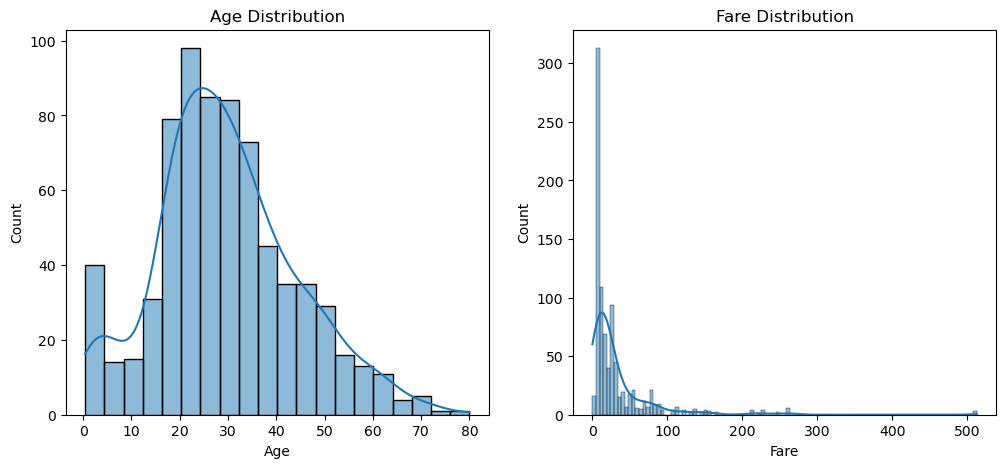

In [4]:
# --- Initial Visualizations for EDA ---
# Plot distribution of Age and Fare
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['Age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.subplot(1, 2, 2)
sns.histplot(train_df['Fare'], kde=True)
plt.title('Fare Distribution')
plt.show()

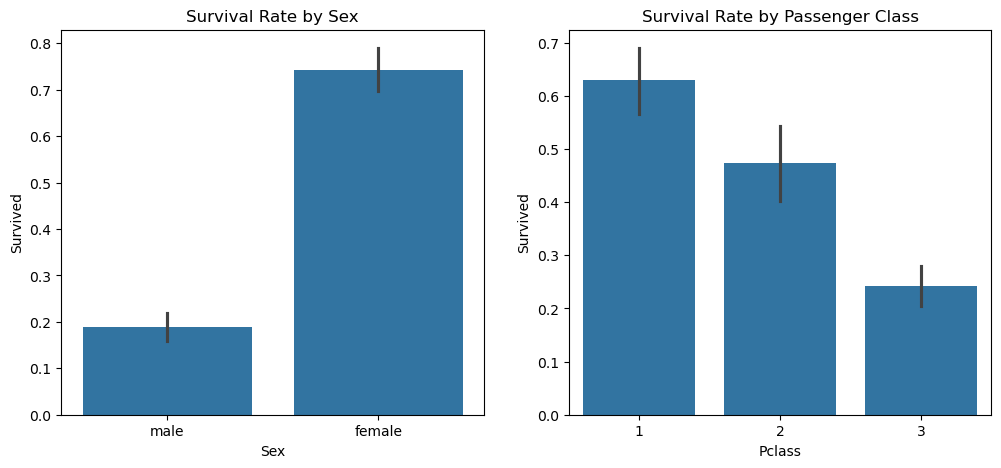

In [5]:
# Visualize survival rates based on Sex and Pclass
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title('Survival Rate by Sex')
plt.subplot(1, 2, 2)
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title('Survival Rate by Passenger Class')
plt.show()

In [6]:
# --- Data Preprocessing and Feature Engineering ---
# Impute missing values
# Age: Impute with median
combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
# Fare: Impute with median
combined_df['Fare'].fillna(combined_df['Fare'].median(), inplace=True)
# Embarked: Impute with mode
combined_df['Embarked'].fillna(combined_df['Embarked'].mode()[0], inplace=True)

C:\Users\vishu_pdk4f5i\AppData\Local\Temp\ipykernel_6116\566211338.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
C:\Users\vishu_pdk4f5i\AppData\Local\Temp\ipykernel_6116\566211338.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [7]:
# Drop columns that are not useful for modeling
combined_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Encode categorical variables
# Use one-hot encoding for 'Sex' and 'Embarked'
combined_df = pd.get_dummies(combined_df, columns=['Sex', 'Embarked'], drop_first=True, dtype=int)

# --- Feature Engineering ---
# Create a new feature 'FamilySize' from SibSp and Parch
combined_df['FamilySize'] = combined_df['SibSp'] + combined_df['Parch'] + 1
# Drop the original columns as they are now captured in FamilySize
combined_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Separate the combined data back into training and testing sets
X = combined_df.iloc[:len(train_df)]
y = train_df['Survived']
X_test_final = combined_df.iloc[len(train_df):]

print("\n--- Data Preprocessing Complete ---")
print("\nProcessed Training Data Info:")
X.info()
print("\nFirst 5 rows of Processed Training Data:")
print(X.head())


--- Data Preprocessing Complete ---

Processed Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         891 non-null    float64
 2   Fare        891 non-null    float64
 3   Sex_male    891 non-null    int32  
 4   Embarked_Q  891 non-null    int32  
 5   Embarked_S  891 non-null    int32  
 6   FamilySize  891 non-null    int64  
dtypes: float64(2), int32(3), int64(2)
memory usage: 38.4 KB

First 5 rows of Processed Training Data:
   Pclass   Age     Fare  Sex_male  Embarked_Q  Embarked_S  FamilySize
0       3  22.0   7.2500         1           0           1           2
1       1  38.0  71.2833         0           0           0           2
2       3  26.0   7.9250         0           0           1           1
3       1  35.0  53.1000         0           0           1           2
4

In [8]:
# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- XGBoost Model ---
print("\n--- Training and Tuning XGBoost ---")
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_val)

# --- LightGBM Model ---
print("\n--- Training and Tuning LightGBM ---")
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31]
}
lgb_grid = GridSearchCV(lgb_model, lgb_param_grid, cv=5, scoring='accuracy')
lgb_grid.fit(X_train, y_train)
lgb_best = lgb_grid.best_estimator_
lgb_pred = lgb_best.predict(X_val)

# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    return [accuracy, precision, recall, f1]

xgb_metrics = evaluate_model(y_val, xgb_pred, 'XGBoost')
lgb_metrics = evaluate_model(y_val, lgb_pred, 'LightGBM')


--- Training and Tuning XGBoost ---

--- Training and Tuning LightGBM ---
[LightGBM] [Info] Number of positive: 214, number of negative: 355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376098 -> initscore=-0.506142
[LightGBM] [Info] Start training from score -0.506142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 214, number of negative: 355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightG


--- Model Performance Comparison ---
      Metric   XGBoost  LightGBM
0   Accuracy  0.810056  0.815642
1  Precision  0.812500  0.788732
2     Recall  0.702703  0.756757
3   F1-Score  0.753623  0.772414


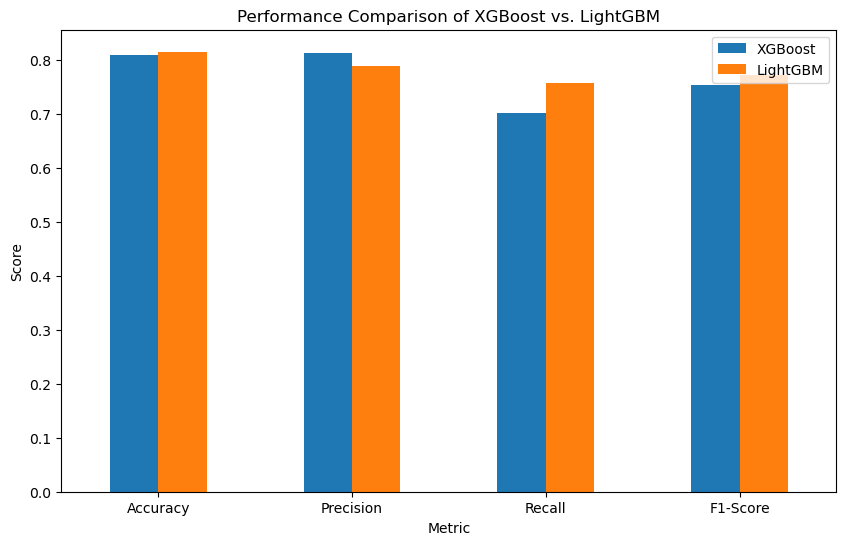

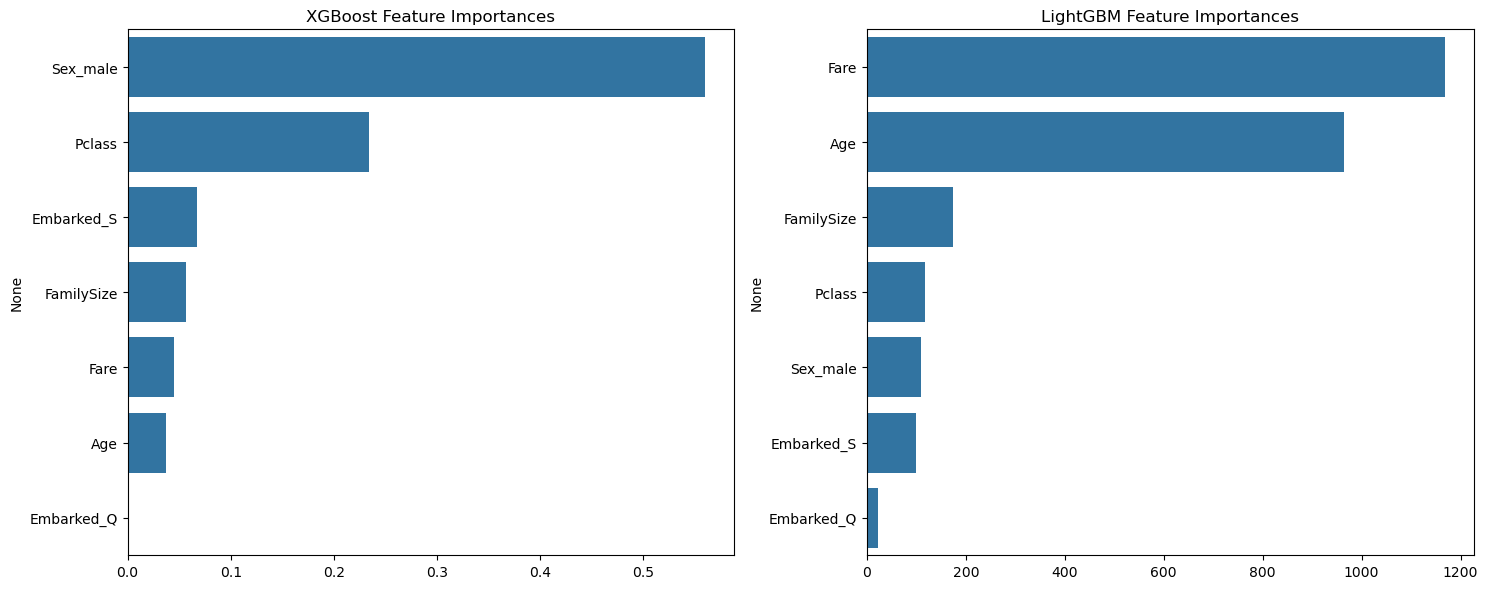


--- Comparative Analysis ---
Both models perform similarly, but LightGBM often trains faster and is more memory-efficient due to its leaf-wise tree growth approach. The feature importance plots show which features each model considered most important for predicting survival.


In [9]:
# --- Comparative Analysis and Visualization ---
models = ['XGBoost', 'LightGBM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
performance_df = pd.DataFrame({
    'Metric': metrics,
    'XGBoost': xgb_metrics,
    'LightGBM': lgb_metrics
})

print("\n--- Model Performance Comparison ---")
print(performance_df)

# Visualize performance comparison
performance_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of XGBoost vs. LightGBM')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Feature Importances
xgb_importances = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)
lgb_importances = pd.Series(lgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=xgb_importances.values, y=xgb_importances.index)
plt.title('XGBoost Feature Importances')
plt.subplot(1, 2, 2)
sns.barplot(x=lgb_importances.values, y=lgb_importances.index)
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

print("\n--- Comparative Analysis ---")
print("Both models perform similarly, but LightGBM often trains faster and is more memory-efficient due to its leaf-wise tree growth approach. The feature importance plots show which features each model considered most important for predicting survival.")